In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
TRAIN_DIR = 'C:/Development/IA/2/train'
TEST_DIR = 'C:/Development/IA/2/test'
IMG_SIZE = 50
LR = 1e-3 
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic-video')

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog':return [0,1]


In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
         label = label_img(img)
         path  =os.path.join(TRAIN_DIR,img)
         img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
         training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)    
    np.save('train_data.npy',training_data)   
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    np.save('test_data.npy',testing_data)   
    return testing_data

In [5]:
#if we dont have it yet
train_data = create_train_data() 
#if we already have the file 
#train_data = np.load('train_data.npy')

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:31<00:00, 795.63it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tflearn.datasets.mnist as mnist

import tensorflow as tf
tf.compat.v1.reset_default_graph()


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')


Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
    

INFO:tensorflow:Restoring parameters from C:\Users\moane\Desktop\catsvsdogs\dogsvscats-0.001-6conv-basic-video.model
model loaded!


In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [ ]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

In [ ]:
#to open Tensorboard with cmd
#tensorboard --logdir=C:\Users\moane\Desktop\catsvsdogs\log

In [10]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\moane\Desktop\catsvsdogs\dogsvscats-0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:24<00:00, 506.51it/s]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


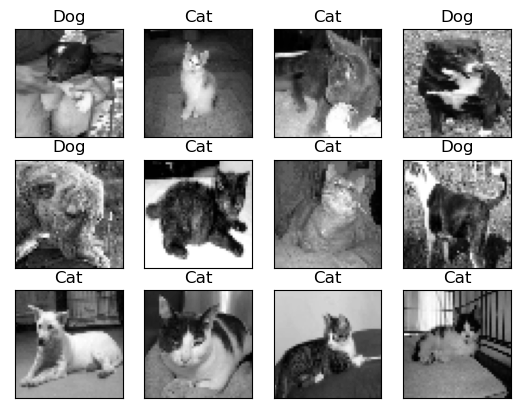

In [11]:
import matplotlib.pyplot as plt

#if we dont have the file yet
test_data = process_test_data()
#if we already have the file
#test_data = np.load('test_data.npy') 
fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    #cat : [1,0]
    #dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1 : str_label ='Dog'
    else : str_label='Cat'
    
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    

In [ ]:
import tkinter as tk
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
from tensorflow import keras
from keras.models import load_model



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    #model.load(MODEL_NAME)
    model.load('dogsvscats-0.001-6conv-basic-video.model')
    print('model loaded!')
    
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('CatsVSDogs Classification')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
sign = ''

def classify(file_path):
    global label_packed
    img = cv2.resize(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
    data = img.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1 :      
        sign='dog'  
        print(sign)
    else :  
        sign='cat'  
        print(sign)
    label.configure(foreground='#011638', text=sign) 
    
    
    
    
def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",
   command=lambda: classify(file_path),
   padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="CatsVSDogs Classification",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()


INFO:tensorflow:Restoring parameters from C:\Users\moane\Desktop\catsvsdogs\dogsvscats-0.001-6conv-basic-video.model
model loaded!
cat
dog
cat
cat
